# Housing Price Predictor

### Full Disclosure:
This notebook has been adapted from the notebook: Car_Price_Prediction.ipynb It was downloaded from the course page

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Dropping the id column

In [3]:
df.drop('Id', axis = 1, inplace = True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

A few columns have too many null values. We may have to drop them. Also some numeric columns may be treated as categorical (such YrSold, MoSold, etc)

In [5]:
as_object = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
df[as_object] = df[as_object].astype('object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

### Dropping columns with more than 30% null values. 30% is an arbitrary value

In [7]:
NA_Cols = []
for c in df.columns:
    if df[c].isna().sum() >= (0.3 * len(df)):
        NA_Cols += [c]
        df.drop(c, axis = 1, inplace = True)
print(NA_Cols)
print(df.head())

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0         60       RL         65.0     8450   Pave      Reg         Lvl   
1         20       RL         80.0     9600   Pave      Reg         Lvl   
2         60       RL         68.0    11250   Pave      IR1         Lvl   
3         70       RL         60.0     9550   Pave      IR1         Lvl   
4         60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0    AllPub    Inside       Gtl  ...             0         0           0   
1    AllPub       FR2       Gtl  ...             0         0           0   
2    AllPub    Inside       Gtl  ...             0         0           0   
3    AllPub    Corner       Gtl  ...           272         0           0   
4    AllPub       FR2       Gtl  ...             0         0           0   

  PoolArea MiscVal MoSold YrSold 

### Extracting numeric fields and calculating correlation

In [8]:
housing_numeric = df.select_dtypes(include=['float64', 'int64'])

In [9]:
housing_cor = housing_numeric.corr()

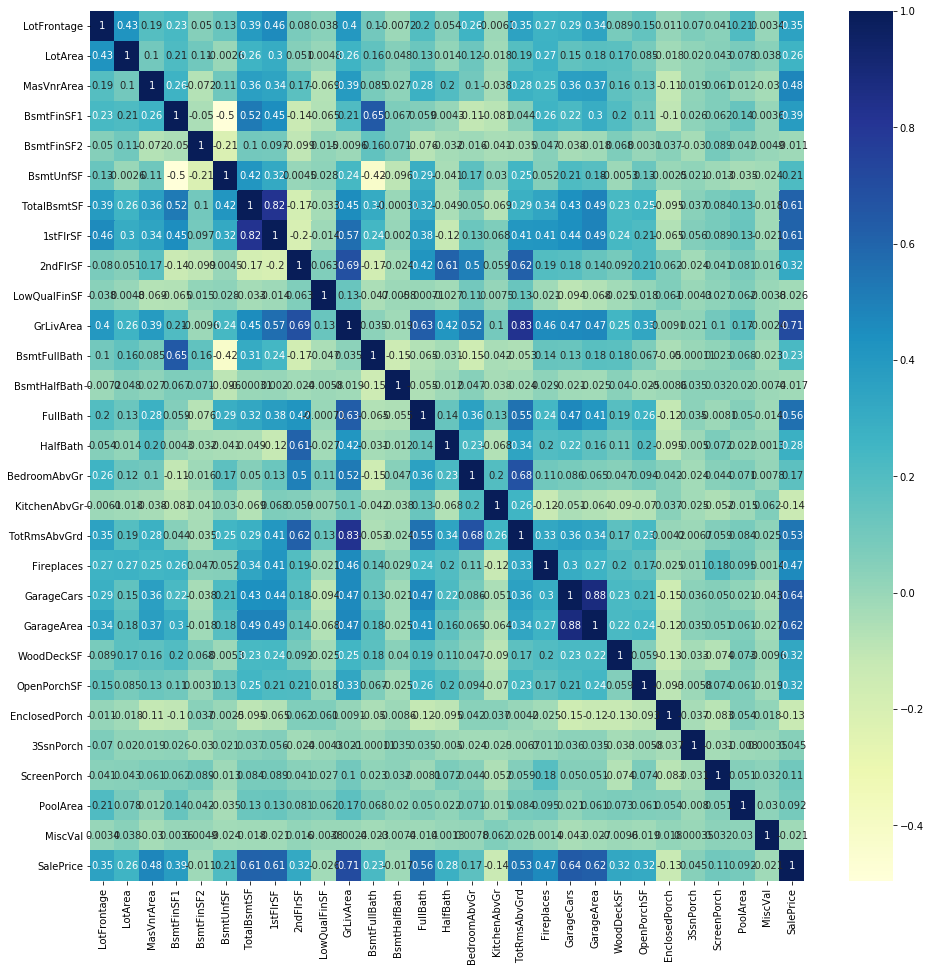

In [10]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,16))

# heatmap
sns.heatmap(housing_cor, cmap="YlGnBu", annot=True)
plt.show()


Overall, we dont see too much correlation. Negative correlation is never more than -0.4. A few attributes are positively correlated though (Totrmsabvgrd & GrLivArea) and we may need to watch out for them. May be we can run VIF to see if they need to be dropped

#### Extracting target variable in to Y variable

In [11]:
y = df['SalePrice'].values
df.drop('SalePrice', axis = 1, inplace=True)

### Extracting and getting dummies for categorical features

In [12]:
housing_categorical = df.select_dtypes(include=['object'])

In [13]:
housing_dummies = pd.get_dummies(housing_categorical, drop_first=True)

In [14]:
df.drop(list(housing_categorical.columns), axis = 1, inplace = True)

### Consolidating Categorical and Numeric features in to 1 dataset

In [15]:
X = pd.concat([df, housing_dummies], axis = 1)

In [16]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale, MinMaxScaler

scaler = MinMaxScaler()


cols = X.columns


Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=537)

In [17]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## Linear Regression

In [18]:
# Instantiate
lm = LinearRegression()
X_train = scaler.fit_transform(np.nan_to_num(X_train))
X_test = scaler.transform(np.nan_to_num(X_test))
# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [19]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-1.2054400326536718e+16
[ 4.85807441e+03  1.54752861e+05  1.79284261e+04 -1.28016903e+16
 -3.34331883e+15 -5.29850258e+15  1.38586690e+16 -6.74671530e+15
 -3.22499238e+15 -8.04295921e+14  8.12729315e+15  3.29631250e+03
 -8.02562500e+03  4.96975000e+03 -2.75750000e+03 -3.86970000e+04
 -1.07255000e+04 -3.62750000e+02 -3.15156250e+03  2.91257500e+04
 -4.65000000e+01  2.82703125e+03  1.16462969e+04  8.80356250e+03
  3.85641250e+04  1.51128750e+04  4.59952500e+04 -6.93115625e+03
  1.31843750e+03 -9.86961719e+03 -2.53330625e+04 -1.95762500e+03
  6.41425000e+03  2.75025000e+03 -2.72785625e+04 -3.41743750e+03
 -1.62260078e+04  1.93056727e+13  2.21350000e+03  5.86775000e+03
 -1.02781250e+03 -1.17453532e+15  3.58301250e+04  3.75121875e+04
  4.09140000e+04  2.99595000e+04  4.38212500e+03  2.47025000e+03
  6.48031250e+03  9.87000000e+02 -2.67150000e+03 -9.87968750e+03
  6.65750000e+02 -1.15843281e+04  7.85750000e+03 -7.01550000e+03
  4.64084375e+03 -1.11350000e+03  1.06500000e+03 -4.35484062e+04
 

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

0.9694230425335247
-4.891668235721859e+20


R2 score for test data is a large negative number. not sure how this is possible. May be there is a problem with scaling

### Ridge Regression
We will do a gridsearch to find optimal lambda/alpha value

In [21]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [22]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 10.0}


In [63]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)


Ridge(alpha=10)

In [64]:
print(ridge.coef_)

[ 1.90137174e+02  1.19354296e+04  1.78472150e+04  1.02858923e+04
  1.00820359e+04  1.72242771e+04  1.85188885e+04  2.82507194e+04
  3.84584653e+04 -1.83337111e+03  3.85310631e+04  1.82202422e+04
  2.25330038e+03  3.11622814e+04  1.04576977e+04  7.30774004e+03
 -9.93188731e+03  2.77603935e+04  2.01764534e+04  2.95806701e+04
  1.58784334e+04  1.24539214e+04  2.45242499e+03  1.50122709e+03
  7.80381666e+03  7.25617595e+03  1.34285180e+03 -2.82140527e+02
 -6.03010280e+03  4.15893068e+01  7.63168616e+02  2.26292494e+03
 -7.28273926e+02  4.82234383e+03  2.54248440e+03 -1.70069718e+03
 -2.65393743e+03 -3.80090887e+03 -1.01741613e+04 -6.97422949e+03
 -4.03634207e+03 -6.75806648e+03  4.27936989e+03  4.36018002e+03
  7.27523494e+03  9.86874473e+02  5.57131423e+02  2.78522221e+03
 -5.78940188e+03  8.60651983e+02  7.91659837e+03  9.39822674e+03
  1.20245835e+04 -2.84448077e+03  1.13924554e+04 -9.24480696e+03
 -2.53299750e+03 -2.57784607e+03  5.63215272e+03  3.40474268e+03
 -1.05861029e+03 -2.04096

In [62]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

0.8976292588840347
0.8574074257299529


Test R2 scores look better here in Ridge Regression than with Linear Regression

### Lasso Regression

In [25]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [26]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [49]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =100

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=100)

In [50]:
lasso.coef_

array([-0.00000000e+00,  2.94052570e+03,  8.37808260e+03,  0.00000000e+00,
        0.00000000e+00,  4.57483906e+03,  0.00000000e+00,  0.00000000e+00,
        2.55932742e+04, -5.33109786e+03,  2.27766988e+05,  2.12563282e+04,
        0.00000000e+00,  2.41184850e+04,  3.92547550e+03, -0.00000000e+00,
       -3.42030887e+04,  0.00000000e+00,  1.15843598e+04,  4.32663780e+04,
        0.00000000e+00,  4.75962267e+03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.37197316e+03, -0.00000000e+00,  0.00000000e+00,
       -4.05619637e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -4.29965611e+03, -0.00000000e+00,
       -0.00000000e+00, -9.46559015e+02,  0.00000000e+00,  0.00000000e+00,
        5.75450753e+03, -0.00000000e+00,  0.00000000e+00,  2.04269207e+03,
       -2.96064784e+03,  0.00000000e+00,  5.66754374e+03,  9.22524349e+03,
        1.05956849e+04, -

In [65]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

0.9084072942880719
0.8563112585500344


Both Lasso and Ridge perform similarly. Ridge performs slightly better than Lasso

### Metrics Comparison

In [66]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.694230e-01,0.897629,0.908407
1,R2 Score (Test),-4.891668e+20,0.857407,0.856311


### Feature importance

In [67]:
betas = pd.DataFrame(index=cols)
betas.rows = cols
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [68]:
pd.set_option('display.max_rows', None)
betas.head(100)

,Linear,Ridge,Lasso
LotFrontage,4.858074e+03,190.137174,-0.000000
LotArea,1.547529e+05,11935.429648,2940.525697
MasVnrArea,1.792843e+04,17847.215001,8378.082595
BsmtFinSF1,-1.280169e+16,10285.892344,0.000000
BsmtFinSF2,-3.343319e+15,10082.035873,0.000000
BsmtUnfSF,-5.298503e+15,17224.277132,4574.839058
TotalBsmtSF,1.385867e+16,18518.888485,0.000000
1stFlrSF,-6.746715e+15,28250.719355,0.000000
2ndFlrSF,-3.224992e+15,38458.465285,25593.274234
LowQualFinSF,-8.042959e+14,-1833.371114,-5331.097860


#### Sorting Ridge column in descending to get important feature ranking

In [69]:
betas.sort_values('Ridge', ascending = False, inplace = True)

#### These are the top features affecting saleprice positively

In [70]:
betas.head(100)

,Linear,Ridge,Lasso
OverallQual_10,1.019765e+16,39228.599745,92897.013093
GrLivArea,8.127293e+15,38531.063086,227766.987910
2ndFlrSF,-3.224992e+15,38458.465285,25593.274234
Neighborhood_NoRidge,1.851200e+04,33952.405016,36632.791274
OverallQual_9,1.019765e+16,31823.932227,70828.061526
FullBath,4.969750e+03,31162.281398,24118.485010
GarageCars,2.912575e+04,29580.670129,43266.377980
1stFlrSF,-6.746715e+15,28250.719355,0.000000
TotRmsAbvGrd,-3.627500e+02,27760.393459,0.000000
RoofMatl_WdShngl,8.425233e+05,27551.210887,75457.040181


#### These are the top features affecting saleprice negatively

In [71]:
betas.tail(100)

,Linear,Ridge,Lasso
YearBuilt_1926,2.822646e+15,-3011.308807,-0.000000
RoofStyle_Gable,1.595500e+04,-3015.763835,-1770.085914
GarageYrBlt_2002.0,2.146400e+04,-3075.369812,-0.000000
YearBuilt_1946,2.822646e+15,-3093.292618,-0.000000
YearBuilt_1952,1.081704e+15,-3099.401983,-0.000000
YearRemodAdd_1952,1.740942e+15,-3099.401983,-0.000000
YearRemodAdd_2008,9.416875e+03,-3104.649215,-0.000000
HouseStyle_2Story,-6.784500e+03,-3124.191878,-6179.234204
GarageYrBlt_2005.0,2.652025e+04,-3128.516570,-0.000000
GarageType_CarPort,-5.079812e+03,-3152.459318,-0.000000


In [72]:
betas.rows

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=537)

#### We will select top 50 features from both positive and negative feature buckets

In [73]:
cc= pd.concat([betas[:50], betas[-50:]], axis = 0)
cc.head(100)

,Linear,Ridge,Lasso
OverallQual_10,1.019765e+16,39228.599745,92897.013093
GrLivArea,8.127293e+15,38531.063086,227766.987910
2ndFlrSF,-3.224992e+15,38458.465285,25593.274234
Neighborhood_NoRidge,1.851200e+04,33952.405016,36632.791274
OverallQual_9,1.019765e+16,31823.932227,70828.061526
FullBath,4.969750e+03,31162.281398,24118.485010
GarageCars,2.912575e+04,29580.670129,43266.377980
1stFlrSF,-6.746715e+15,28250.719355,0.000000
TotRmsAbvGrd,-3.627500e+02,27760.393459,0.000000
RoofMatl_WdShngl,8.425233e+05,27551.210887,75457.040181


In [32]:
X.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=537)

## Multicollinearity analysis using VIF

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(np.nan_to_num(X.values), i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
222,YearBuilt_1995,inf
182,YearBuilt_1955,inf
180,YearBuilt_1953,inf
179,YearBuilt_1952,inf
119,OverallCond_2,inf
120,OverallCond_3,inf
121,OverallCond_4,inf
122,OverallCond_5,inf
123,OverallCond_6,inf
124,OverallCond_7,inf


# Significant correlation exists. We may benefit by dropping many of these correlated features